In [244]:
# Value at Risk Calculations 

import numpy as np #algebra
import pandas as pd # dataframes
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
from arch import arch_model

def get_data(stocks,start,end):
    stockData = yf.download(stocks, start=start, end=end) 
    stockData = stockData["Close"] #Extracts only the closing price for the data we retrieved 
    returns = stockData.pct_change().dropna() #Computes the returns over consecutive closing prices
    meanReturns = returns.mean() #Calculate the average daily return for each stock
    covMatrix = returns.cov() #Calculate the covariance matrix of the daily returns
    return returns, meanReturns, covMatrix

# Setting up the portfolio

stockList = ["AAPL", "MSFT", "JPM", "V", "UNH", "GS", "HD",
             "PG", "DIS", "NKE", "AXP", "IBM", "MMM", "TRV",
             "CVX", "KO", "MRK", "PFE", "MCD", "WMT", "INTC",
             "CSCO", "VZ", "BA", "CAT", "JNJ", "WBA", "DOW", 
             "AMGN", "HON"]


# Define an end data
endDate = dt.datetime.now() # Current date
startDate = endDate - dt.timedelta(days=300) #start date is 300 days before todays date 

returns, meanReturns, covMatrix = get_data(stockList, startDate, endDate) #Tuple unpacking - returing the (meanReturns, covMatrix) as two seperate variables

# Portfolio weights - of different allocations to the stocks in the portfolio

weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)

[*********************100%***********************]  30 of 30 completed


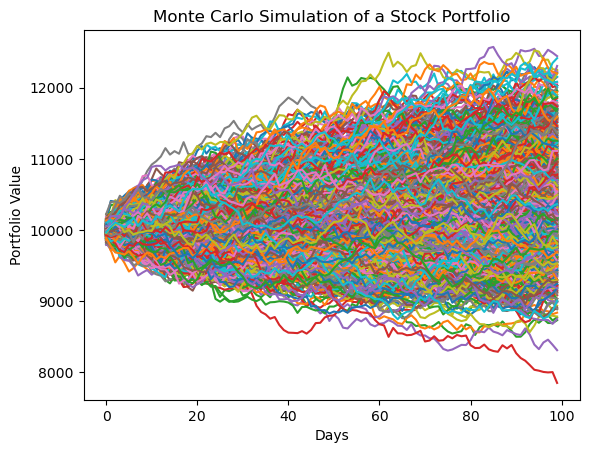

In [246]:
# Monte Carlo Method

mc_sims = 1000 # The number of simulated scenarios, representing the evolution of the portfolio
T = 100 # Number of days we simulate returns 

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) #Creates a matrix of T by No. of stocks; each row starts with a value of mean returns.  
meanM = meanM.T # Shape now is No of stocks by T; Each Column is a single day, each row is a single stocks mean return. 

# E.g. of meanM output: 

# meanM =
# [
# [0.0012, 0.0012, 0.0012, 0.0012, ..., 0.0012],  # 100 times for AAPL if mean return is 0.0012 (0.12% per day)
# [0.0008, 0.0008, 0.0008, 0.0008, ..., 0.0008],  # 100 times for COST if mean return is 0.0008 (0.08% per day)
# [0.0015, 0.0015, 0.0015, 0.0015, ..., 0.0015]   # 100 times for MSFT if mean return is 0.0015 (0.15% per day)
#]

# Initialise an empty matrix to hold the simulation values - will have one row per day (T rows) and one column per simulation (mc_sims columns).
# Store the portfolios path from day 0 to day T 
port_sims = np.full(shape=(T, mc_sims), fill_value=0.0) 

# Create a starting point to see how the portfolio value evolves

initialPortfolio = 10000


# Assuming that daily returns are distributed by a Multivariate Normal Distribution 


for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights))) # Generate a matrix of random values drawn from a standard normal distribution. Each row is a day, each column is a stock
    L = np.linalg.cholesky(covMatrix) # the lower-triangular matrix resulting from the Cholesky decomposition of the covariance matrix. Transformation Matrix

    # Assuming that daily returns are given by the mean + random value which includes correlations, ensuring that the simulated daily returns reflect not just individual stock volatilities, but also how stocks move in relation to each other.
    
    dailyReturns = meanM + np.inner(L, Z) # When we multiply L by Z it converts these independent random draws into correlated random draws.

    # port_sims[:, m] - for the m^th simulation in the loop, take each row and populate it with the portfolio return (monetary value) that day. Do this for all days up to T, for every iteration m. 
    port_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio # np.inner(weights, dailyReturns.T) converts the return of the stock into the return in the portfolio based on the weights - gives total portfolio return
                                                                                      #...'+1' turns the returns into growth factors; np.cumprod() takes the cumulative product of these daily growth factors, giving the total growth of the portfolio over time. Then we multiply by the portfolio value to get monetary value


plt.plot(port_sims)
plt.ylabel("Portfolio Value")
plt.xlabel("Days")
plt.title("Monte Carlo Simulation of a Stock Portfolio")
plt.show()
    
    



In [248]:
# Value-at-Risk from Monte-Carlo

#Input: pandas series of returns
#Output: percentile on returns distribution to a given confidence level alpha

def mcVar(returns, alpha=5): 
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a Pandas Data Series")
    
# Conditional Value at risk - Expected Shortfall below the percentile

#Input: pandas series of returns 
#Output: CVaR or Expected Shortfall to a given confidence level alpha

def mcCVar(returns, alpha=5):
    if isinstance(returns, pd.Series):
        belowVar = returns <= mcVar(returns, alpha=alpha)
        return returns[belowVar].mean()
    else:
        raise TypeError("Expected a Pandas Data Series")


# Return MC simulations at very last time step

portResults = pd.Series(port_sims[-1,:]) #All the columns but for the last row

portValue_VaR = initialPortfolio - mcVar(portResults, alpha=5)
portValue_CVaR = initialPortfolio - mcCVar(portResults, alpha=5)

print(f"The lowest value of the portfolio with 95% confidence = ${portValue_VaR.round(2)}. Meaning we expect to experience a maximum loss of {(mcVar(portResults, alpha=5)).round(2)} from our portfolio value with 95% confidence" )
print(f"The (expected) lowest value of the portfolio if returns are in the worst 5% of cases = ${portValue_CVaR.round(2)}")




The lowest value of the portfolio with 95% confidence = $728.4. Meaning we expect to experience a maximum loss of 9271.6 from our portfolio value with 95% confidence
The (expected) lowest value of the portfolio if returns are in the worst 5% of cases = $960.39


In [206]:
# Value at Risk - Via Quantile Regression (Linear Approach)

Whilst we have estimated the VaR above based on the Monte-Carlo, the VaR is not based on the true returns data. To be able to find VaR with the true returns data, let's look back at VaR which can be defined as:

$$
VaR_{t}(X) = \inf \{x \mid F_{X}(x) \geq \tau\} = F_{X}^{-1}(\tau)
$$

Where $ \tau $ is the specified confidence level, and X is a vector of returns. With such an expression, it's easy to see that this is the same as saying VaR is the $ \tau^{th} $ quantile of the returns distribution X. 

Quantile Regression (Koenker & Bassett Jr, 1978) provides a framework where we can obtain the quantiles of a distribution without requiring any of the classical assumptions. This will work well for financial data, which frequently possesses heavy tails. 

For our QR model, the explanatory variables that we will use will be GARCH(1,1) estimated volatility forecast and mean. This is because GARCH gives us a time-varying estimate of volatility. 

In [259]:
# Function to download data, compute returns, and covariance matrix
def get_data_QR(stocks, start, end):
    
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData["Close"]  # Extract only the closing prices
    returns_QR = stockData.pct_change().dropna()  # Daily returns
    meanReturns_QR = returns_QR.mean()  # Average daily return for each stock
    covMatrix_QR = returns_QR.cov()     # Covariance matrix of daily returns
    return returns_QR, meanReturns_QR, covMatrix_QR


# Setting up the portfolio (same stocks as before)
stockList = ["AAPL", "MSFT", "JPM", "V", "UNH", "GS", "HD",
             "PG", "DIS", "NKE", "AXP", "IBM", "MMM", "TRV",
             "CVX", "KO", "MRK", "PFE", "MCD", "WMT", "INTC",
             "CSCO", "VZ", "BA", "CAT", "JNJ", "WBA", "DOW", 
             "AMGN", "HON"]

# Define start and end dates
endDate = dt.datetime.now()            # Current date
startDate = endDate - dt.timedelta(days=300) # 300 days ago

# Get returns and stats
returns_QR, meanReturns_QR, covMatrix_QR = get_data_QR(stockList, startDate, endDate)

# Set random portfolio weights (similar style as Monte Carlo code)
weights = np.random.random(len(meanReturns_QR))
weights /= np.sum(weights)

# Compute portfolio returns by applying weights to individual stock returns
portfolio_returns = (returns_QR * weights).sum(axis=1)

# Scale portfolio returns to avoid arch_model warnings
portfolio_returns_scaled = portfolio_returns * 100

[*********************100%***********************]  30 of 30 completed


In [261]:
# Create the explanatory variables for the QR model
# Fit a GARCH(1,1) model to the scaled portfolio returns

am_model = arch_model(portfolio_returns_scaled, vol='GARCH', p=1, o=0, q=1, dist='Normal') # GARCH(1,1)
fitted_portfolio = am_model.fit(update_freq=0, disp='off')

# Extract conditional volatility and mean from the fitted GARCH model
conditional_volatility = fitted_portfolio.conditional_volatility
conditional_mean = fitted_portfolio.params['mu']

# Create a DataFrame to hold the returns and explanatory variables for QR
data = pd.DataFrame({
    'returns': portfolio_returns_scaled,
    'sigma': conditional_volatility
}).dropna()

# Add the constant mean (mu) from the GARCH model
data['mu'] = conditional_mean

In [263]:
# Prepare the data for Quantile Regression
X = sm.add_constant(data[['mu', 'sigma']])
y = data['returns']

# Fit Quantile Regression at 5% quantile
quantile_model = sm.QuantReg(y, X)
fitted_quantile = quantile_model.fit(q=0.05)  # 5% quantile (VaR)
print(fitted_quantile.summary())

                         QuantReg Regression Results                          
Dep. Variable:                returns   Pseudo R-squared:             0.007792
Model:                       QuantReg   Bandwidth:                      0.5403
Method:                 Least Squares   Sparsity:                        6.469
Date:                Fri, 06 Dec 2024   No. Observations:                  206
Time:                        00:46:14   Df Residuals:                      204
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mu             6.7661     21.423      0.316      0.752     -35.472      49.004
sigma         -1.9248      1.069     -1.800      0.073      -4.033       0.184


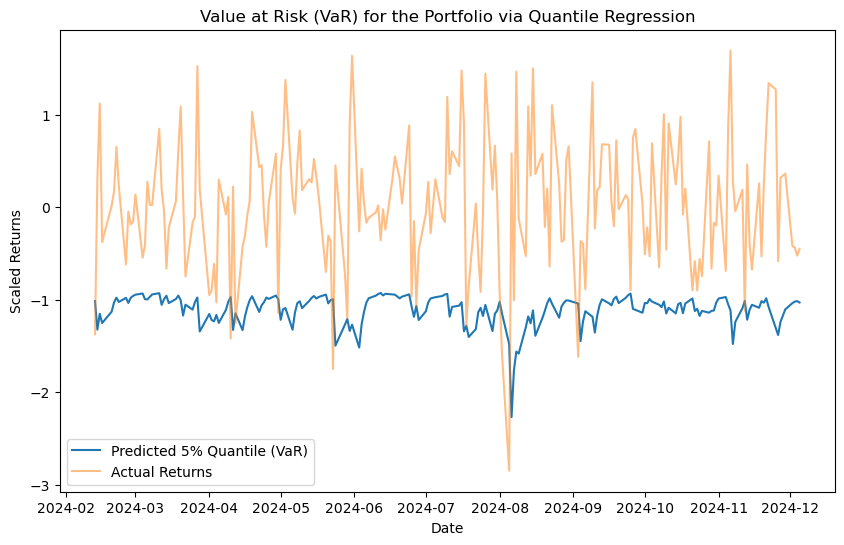

Violation Rate: 5.34%


In [265]:
# Predict VaR using the fitted model
predicted_quantile = fitted_quantile.predict(X)

# Plotting the predicted VaR against actual returns
plt.figure(figsize=(10, 6))
plt.plot(data.index, predicted_quantile, label='Predicted 5% Quantile (VaR)')
plt.plot(data.index, y, label='Actual Returns', alpha=0.5)
plt.title("Value at Risk (VaR) for the Portfolio via Quantile Regression")
plt.xlabel("Date")
plt.ylabel("Scaled Returns")
plt.legend()
plt.show()

# Calculate the violation rate (how often actual returns fall below the predicted VaR)
violations = (y < predicted_quantile).mean()
print(f"Violation Rate: {violations:.2%}")


RECAP: The Value at Risk (VaR) at a certain confidence level τ (e.g., 5%) is the τ-th quantile of the returns distribution. In other words, the VaR at time t is the point such that there is only a τ-probability that the return falls below that point.

During our code above, we ran the quantile regression model using:

Dependent Variable (Y): Actual historical returns of our (randomly) weighted portfolio. Thus, the quantile estimates that the QR model produces are based on the actual observed distribution of returns (no need for assumptions on the returns distribution).

Explanatory Variables (X): The GARCH(1,1) estimated conditional volatility and mean. By using these as regressors, we allow the model to produce a conditional quantile. This means that at each point in time, t, the model estimates the τ-th quantile of the returns given the current level of volatility and mean as indicated by the GARCH model.

The .predict(X) method returns a series of fitted values. Each value is the QR models estimate of the τ-th conditional quantile of returns. These predicted values are what represents the estimated VaR at each time point in the dataset. 

The violation rate tells us the average number of times our portfolio returns fall below the predicted 5% quantile.

In [242]:
## NEXT STEP

# Value at Risk - Via Quantile Regression (Non-linear Approach with Neural Networks)

# See: Xu, Q., Liu, X., Jiang, C. & Yu, K. (2016), ‘Quantile autoregression neural network model with applications to evaluating value at risk’,


# Potential steps: 
# (1) use the same data collection as before and use the same portfolio
# (2) Fit a GARCH(1,1) model to the data to find the explanatory variables again. As this will be good information for the NN 
# because it gets a measure of conditional volatility at each point in time. Which can help the NN understand how the distribution of returns changes when volatility is high or low.
# (3) design a neural network to predict the τ-th quantile of the return distribution directly, at time t. (?)
# (4) Train the Neural Network (?)
# (5) Obtain VaR - which should effectively be the τ-th quantile of the return distribution.


